# Pitt Corpus Data Analysis & Visualization

This notebook provides a comprehensive analysis and visualization of the Pitt Corpus dataset used for Dementia detection. It covers:
1.  **Data Distribution**: Bar and Pie charts showing the balance between Dementia and Control groups.
2.  **Spectrogram Analysis**: Visualization of pre-computed spectrograms.
3.  **Advanced Linguistic Analysis**: Analysis of transcript lengths, vocabulary richness (Type-Token Ratio), and speech rate (words per second).
4.  **Data Splitting**: Robust train-test-validation splitting strategy ensuring no data leakage at the patient level.

In [1]:
import importlib
import subprocess
import sys

def check_and_install_libraries(libraries):
    """
    Checks if libraries are installed and installs them if not.
    """
    print("Checking and installing required libraries...")
    for library, package_name in libraries.items():
        try:
            importlib.import_module(library)
            print(f"   [OK] '{library}' is already installed.")
        except ImportError:
            print(f"   [MISSING] '{library}' not found. Installing '{package_name}'...")
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
                print(f"   [INSTALLED] '{package_name}' installed successfully.")
            except subprocess.CalledProcessError:
                print(f"   [ERROR] Failed to install '{package_name}'. Please install it manually.")

# List of libraries to check (import_name: package_name)
required_libraries = {
    "numpy": "numpy",
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "librosa": "librosa",
    "sklearn": "scikit-learn"
}

check_and_install_libraries(required_libraries)

# Now import them
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import random

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Checking and installing required libraries...
   [OK] 'numpy' is already installed.
   [OK] 'pandas' is already installed.
   [OK] 'matplotlib' is already installed.
   [OK] 'seaborn' is already installed.
   [OK] 'librosa' is already installed.
   [OK] 'sklearn' is already installed.


## 1. Data Loading and Distribution

First, we define the paths and load the dataset metadata. We handle the slight naming inconsistency (`dementia`/`ad` vs `control`/`cn`) by mapping them to standardized 'Dementia' and 'Control' labels.

In [2]:
# Define base paths
BASE_PATH = r"d:\Uni\thesis final"
WAV_PATH = os.path.join(BASE_PATH, "wav")
SPECTO_PATH = os.path.join(BASE_PATH, "specto")
TRANS_PATH = os.path.join(BASE_PATH, "trans")

# Define Categories mapping
# wav uses: 'dementia', 'control'
# specto/trans use: 'ad', 'cn'
CATEGORIES = {
    'Dementia': {'wav': 'dementia', 'specto': 'ad', 'trans': 'ad'},
    'Control': {'wav': 'control', 'specto': 'cn', 'trans': 'cn'}
}

data_records = []

for label, paths in CATEGORIES.items():
    wav_dir = os.path.join(WAV_PATH, paths['wav'])
    if not os.path.exists(wav_dir):
        print(f"Warning: Directory not found: {wav_dir}")
        continue

    # Walk through wav directory
    for f in os.listdir(wav_dir):
        if f.endswith('.mp3'):
            file_id = f.replace('.mp3', '')
            patient_id = file_id.split('-')[0]  # Extract patient ID for splitting
            
            record = {
                'id': file_id,
                'patient_id': patient_id,
                'label': label,
                'wav_path': os.path.join(wav_dir, f),
                'specto_path': os.path.join(SPECTO_PATH, paths['specto'], file_id + '.png'),
                'trans_path': os.path.join(TRANS_PATH, paths['trans'], file_id + '.txt')
            }
            data_records.append(record)

df = pd.DataFrame(data_records)
print(f"Total samples loaded: {len(df)}")
df.head()

Total samples loaded: 552


,id,patient_id,label,wav_path,specto_path,trans_path
0,001-0,001,Dementia,d:\Uni\thesis final\wav\dementia\001-0.mp3,d:\Uni\thesis final\specto\ad\001-0.png,d:\Uni\thesis final\trans\ad\001-0.txt
1,001-2,001,Dementia,d:\Uni\thesis final\wav\dementia\001-2.mp3,d:\Uni\thesis final\specto\ad\001-2.png,d:\Uni\thesis final\trans\ad\001-2.txt
2,003-0,003,Dementia,d:\Uni\thesis final\wav\dementia\003-0.mp3,d:\Uni\thesis final\specto\ad\003-0.png,d:\Uni\thesis final\trans\ad\003-0.txt
3,005-0,005,Dementia,d:\Uni\thesis final\wav\dementia\005-0.mp3,d:\Uni\thesis final\specto\ad\005-0.png,d:\Uni\thesis final\trans\ad\005-0.txt
4,005-2,005,Dementia,d:\Uni\thesis final\wav\dementia\005-2.mp3,d:\Uni\thesis final\specto\ad\005-2.png,d:\Uni\thesis final\trans\ad\005-2.txt


### Class Distribution Visualization

Here we visualize the balance between the Dementia and Control classes using both Bar and Pie charts.

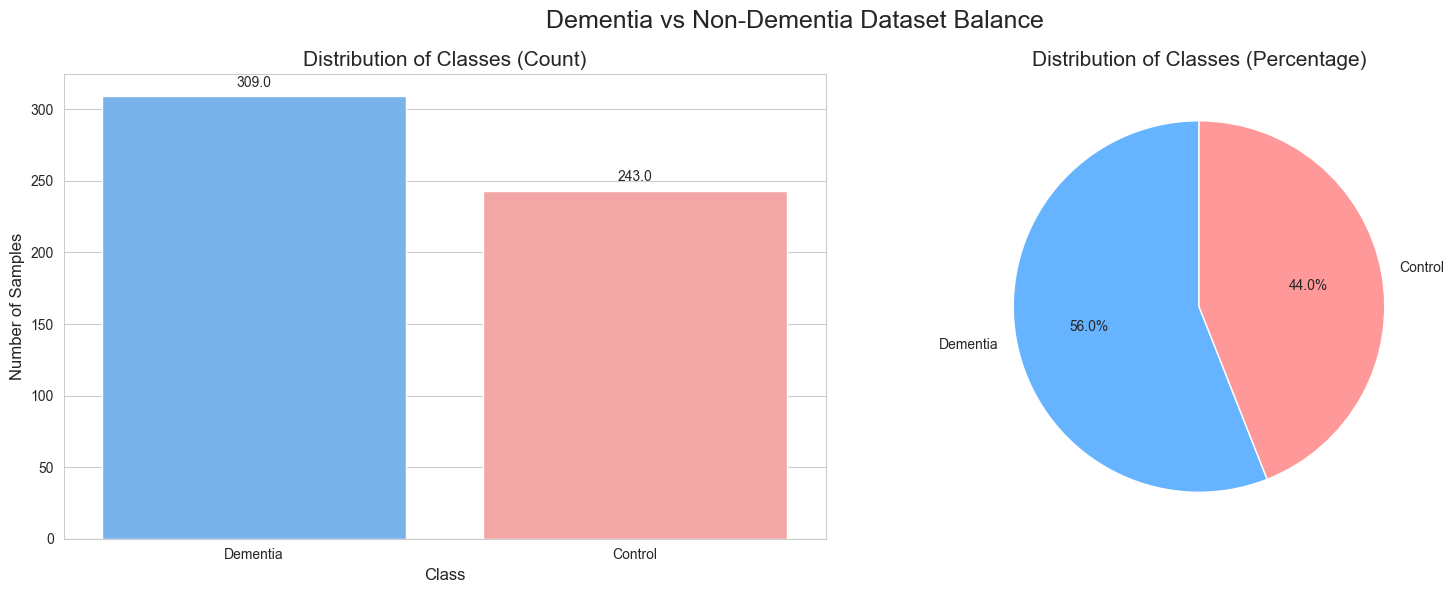

In [3]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar Chart
sns.countplot(data=df, x='label', hue='label', palette=['#66b3ff', '#ff9999'], legend=False, ax=ax[0])
ax[0].set_title('Distribution of Classes (Count)', fontsize=15)
ax[0].set_xlabel('Class', fontsize=12)
ax[0].set_ylabel('Number of Samples', fontsize=12)
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Pie Chart
counts = df['label'].value_counts()
ax[1].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
ax[1].set_title('Distribution of Classes (Percentage)', fontsize=15)

plt.suptitle("Dementia vs Non-Dementia Dataset Balance", fontsize=18)
plt.tight_layout()
plt.show()

## 2. Spectrogram Analysis

**Existing Generated Spectrograms**: Displaying the `.png` files already prepared in the `specto` folder.

In [ ]:
import math
import os
import matplotlib.pyplot as plt

def plot_all_spectrograms_by_class(df, label_col='label', path_col='specto_path', id_col='id'):
    classes = df[label_col].unique()
    
    for cls in classes:
        class_df = df[df[label_col] == cls]
        num_imgs = len(class_df)
        
        if num_imgs == 0:
            continue

        cols = 5  # number of images per row
        rows = math.ceil(num_imgs / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
        axes = axes.flatten()

        for i, (_, row) in enumerate(class_df.iterrows()):
            ax = axes[i]
            if os.path.exists(row[path_col]):
                img = plt.imread(row[path_col])
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"{cls} ({row[id_col]})", fontsize=8)
            else:
                ax.text(0.5, 0.5, "Image not found", ha='center')
                ax.axis('off')

        # Turn off unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        fig.suptitle(f"All Spectrograms — {cls}", fontsize=16)
        plt.tight_layout()
        plt.show()


print(f"All Dementia vs Non-Dementia Spectrograms:")
plot_all_spectrograms_by_class(df)


All Dementia vs Non-Dementia Spectrograms:


## 3. Advanced Transcription & Linguistic Analysis

The dataset includes transcriptions for the audio files. We compute three key metrics:
1.  **Word Count**: Total number of words in the transcript.
2.  **Type-Token Ratio (TTR)**: Measure of vocabulary richness (unique words / total words).
3.  **Speech Rate**: Words per second (requires audio duration).

These metrics are often critical markers for cognitive impairment.

Calculating linguistic metrics... this may take a minute...
Calculation complete.


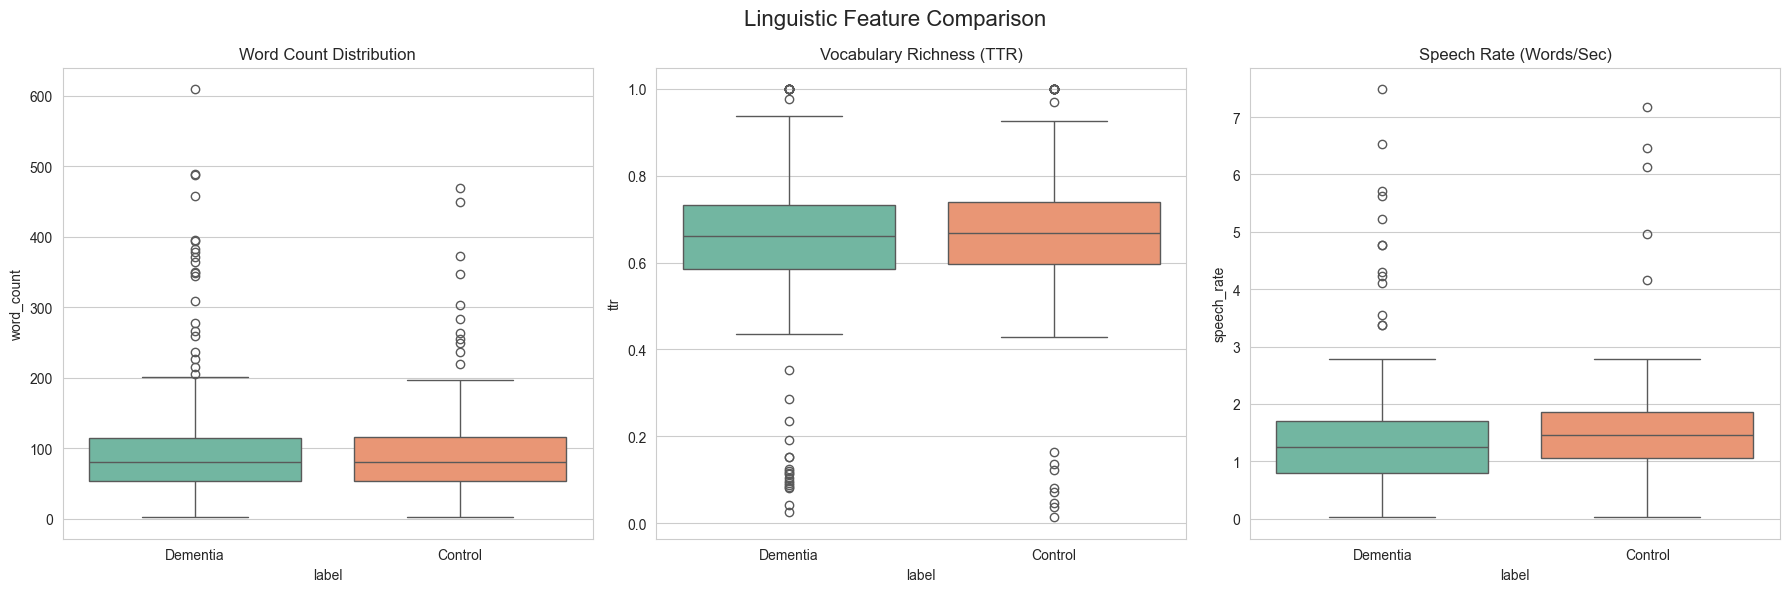

Sample Transcript (Dementia):
 oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh...


In [ ]:
def analyze_transcript_and_audio(row):
    # Initialize defaults
    word_count = 0
    unique_words = 0
    ttr = 0.0
    duration = 0.0
    speech_rate = 0.0
    text_content = ""

    # 1. Analyze Transcript
    try:
        if os.path.exists(row['trans_path']):
            with open(row['trans_path'], 'r', encoding='utf-8') as f:
                text = f.read()
                text_content = text
                words = text.split()
                word_count = len(words)
                if word_count > 0:
                    unique_words = len(set(words))
                    ttr = unique_words / word_count
    except Exception as e:
        pass

    # 2. Get Audio Duration
    try:
        if os.path.exists(row['wav_path']):
            duration = librosa.get_duration(path=row['wav_path'])
    except:
        pass

    # 3. Compute Speech Rate
    if duration > 0:
        speech_rate = word_count / duration

    return pd.Series([word_count, ttr, duration, speech_rate, text_content], 
                     index=['word_count', 'ttr', 'duration', 'speech_rate', 'transcript'])

# Apply calculations
print("Linguistic Metrics")
metrics_df = df.apply(analyze_transcript_and_audio, axis=1)
df = pd.concat([df, metrics_df], axis=1)

# Visualize Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='label', hue='label', y='word_count', data=df, palette="Set2", ax=axes[0])
axes[0].set_title('Word Count Distribution')

sns.boxplot(x='label', hue='label', y='ttr', data=df, palette="Set2", ax=axes[1])
axes[1].set_title('Vocabulary Richness (TTR)')

sns.boxplot(x='label', hue='label', y='speech_rate', data=df, palette="Set2", ax=axes[2])
axes[2].set_title('Speech Rate (Words/Sec)')

plt.suptitle("Linguistic Feature Comparison", fontsize=16)
plt.tight_layout()
plt.show()

# Display a sample transcript
print("Sample Transcript (Dementia):")
print(df[df['label'] == 'Dementia']['transcript'].iloc[0][:300] + "...")

## 4. Train - Test - Validation Split

**Crucial Import**: We perform the split based on `patient_id`. Since a single patient might have multiple audio recordings, splitting randomly by file would cause **data leakage** (segments of the same patient appearing in both train and test sets). By splitting by patient ID, we ensure the model generalizes to new speakers.

Split Statistics (Number of Samples):
label       Control  Dementia
split                        
Test             27        56
Train           182       203
Validation       34        50


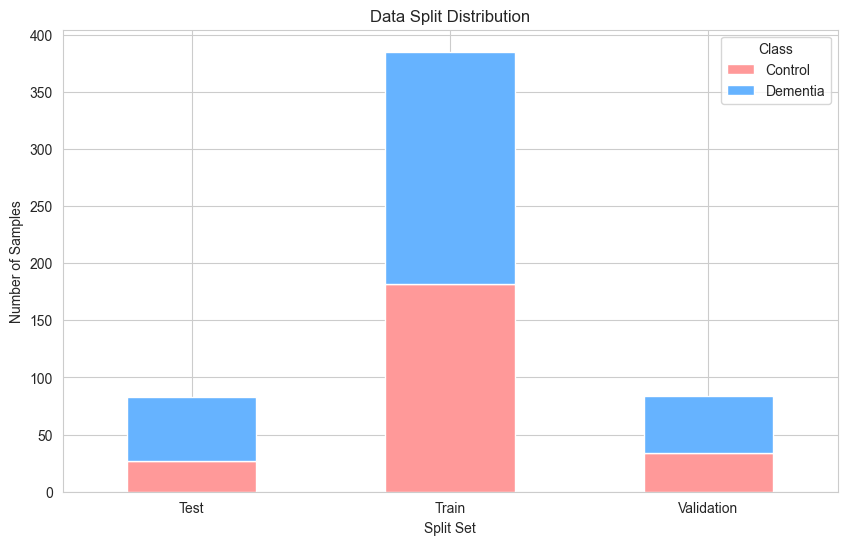

In [ ]:
# Get unique patient IDs and their labels
# We take the first label found for each patient (assuming a patient doesn't change class)
patient_labels = df.groupby('patient_id')['label'].first()
patients = patient_labels.index.to_numpy()
labels = patient_labels.to_numpy()

# Split: 70% Train, 15% Validation, 15% Test
X_train_ids, X_temp_ids, y_train, y_temp = train_test_split(
    patients, labels, test_size=0.30, random_state=42, stratify=labels
)

X_val_ids, X_test_ids, y_val, y_test = train_test_split(
    X_temp_ids, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Map splits back to the original DataFrame
df['split'] = 'Unassigned'
df.loc[df['patient_id'].isin(X_train_ids), 'split'] = 'Train'
df.loc[df['patient_id'].isin(X_val_ids), 'split'] = 'Validation'
df.loc[df['patient_id'].isin(X_test_ids), 'split'] = 'Test'

# Verify the split
split_counts = df.groupby(['split', 'label']).size().unstack(fill_value=0)

print("Split Statistics (Number of Samples):")
print(split_counts)

# Visualize Split
split_counts.plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'], figsize=(10, 6))
plt.title("Data Split Distribution")
plt.xlabel("Split Set")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.legend(title='Class')
plt.show()

### Save Split Metadata
We save the split information to a CSV file so it can be used by training scripts.

In [ ]:
output_csv_path = os.path.join(BASE_PATH, "1. Data Visualisation", "dataset_splits.csv")
df[['id', 'patient_id', 'label', 'split', 'wav_path', 'specto_path', 'trans_path', 
    'word_count', 'ttr', 'duration', 'speech_rate']].to_csv(output_csv_path, index=False)
print(f"Split metadata saved to: {output_csv_path}")

Split metadata saved to: d:\Uni\thesis final\1. Data Visualisation\dataset_splits.csv
